# Analysis and visualization of spatial transcriptomics data

This tutorial shows how to work with multiple Visium datasets and perform integration of scRNA-seq dataset with **Scanpy**. It follows the [previous tutorial](https://github.com/theislab/scanpy-tutorials/blob/master/analysis-visualization-spatial.ipynb) on analysis and visualization of spatial transcriptomics data.

We will use **Scanorama** [paper](https://www.nature.com/articles/s41587-019-0113-3) - [code](https://github.com/brianhie/scanorama) to perform integration and label transfer. It has a convenient interface with scanpy and anndata. 

To install the required libraries, type the following:

```
pip install git+https://github.com/theislab/scanpy.git
pip install git+https://github.com/theislab/anndata.git
pip install scanorama
```

### Loading libraries

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import scanorama

%load_ext lab_black
%load_ext autoreload
%autoreload 2

mpl.use("module://ipykernel.pylab.backend_inline")
plt.rcParams["figure.figsize"] = (5, 5)

/Users/giovanni.palla/miniconda3/envs/scanpy_dev/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Reading the data

We will use two **Visium** spatial transcriptomics dataset of the mouse brain (Sagittal), which are publicly available from the [10x genomics website](https://support.10xgenomics.com/spatial-gene-expression/datasets/).

The function `datasets.visium_sge()` downloads the dataset from 10x genomics and returns an AnnData object that contains counts, images and spatial coordinates. We will calculate standards QC metrics with `pp.calculate_qc_metrics` and visualize them.

When using your own Visium data, use Scanpy's [`read_visium()`](https://icb-scanpy.readthedocs-hosted.com/en/latest/api/scanpy.read_visium.html) function to import it.


In [2]:
adata_spatial_anterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Anterior"
)
adata_spatial_posterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Posterior"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata_spatial_anterior.var_names_make_unique()
adata_spatial_posterior.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_spatial_anterior, inplace=True)
sc.pp.calculate_qc_metrics(adata_spatial_posterior, inplace=True)

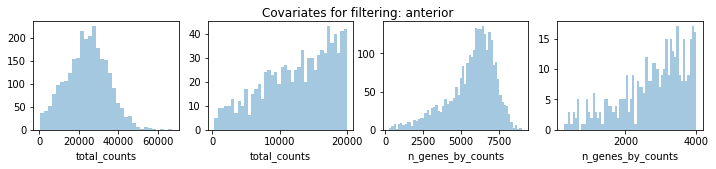

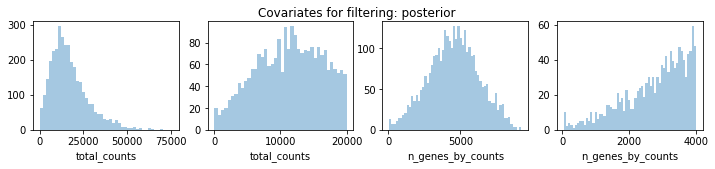

In [4]:
for name, adata in [
    ("anterior", adata_spatial_anterior),
    ("posterior", adata_spatial_posterior),
]:
    fig, axs = plt.subplots(1, 4, figsize=(12, 2))
    fig.suptitle(f"Covariates for filtering: {name}")

    sb.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sb.distplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[1],
    )
    sb.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sb.distplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[3],
    )

`sc.datasets.visium_sge` downloads the *filtered* visium dataset, the output of [spaceranger](https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/what-is-space-ranger) that contains only spots within the tissue slice. Indeed, looking at standard QC metrics we can observe that the samples do not contain empty spots.

We proceed to normalize Visium counts data with the built-in `normalize_total` method from Scanpy, and detect highly-variable genes (for later). As discussed previously, note that there are more sensible alternatives for normalization (see discussion in [sc-tutorial paper](https://www.embopress.org/doi/full/10.15252/msb.20188746) and more recent alternatives such as [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) or [GLM-PCA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)).

In [5]:
for adata in [
    adata_spatial_anterior,
    adata_spatial_posterior,
]:
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

### Data integration

We are now ready to perform integration of the two dataset. As mentioned before, we will be using Scanorama for that. Scanorama returns two lists, one for the integrated embeddings and one for the corrected counts, for each dataset.

In [6]:
adatas = [adata_spatial_anterior, adata_spatial_posterior]
# Integration.
integrated, corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 31053 genes among all datasets
[[0.         0.48165822]
 [0.         0.        ]]
Processing datasets (0, 1)


We will concatenate the two datasets and save the integrated embeddings in `adata_spatial.obsm['scanorama_embedding']`. Furthermore we will compute UMAP to visualize the results and qualitatively assess the data integration task.

Notice that we are concatenating the two dataset with `uns_merge="unique"` strategy, in order to keep both images from the visium datasets in the concatenated anndata object.

In [7]:
adata_spatial = adata_spatial_anterior.concatenate(
    adata_spatial_posterior,
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=[
        k
        for d in [
            adata_spatial_anterior.uns["spatial"],
            adata_spatial_posterior.uns["spatial"],
        ]
        for k, v in d.items()
    ],
)

In [8]:
embedding = np.concatenate(integrated, axis=0)
adata_spatial.obsm["scanorama_embedding"] = embedding
sc.pp.neighbors(adata_spatial, use_rep="scanorama_embedding")
sc.tl.umap(adata_spatial)
sc.tl.louvain(adata_spatial, key_added="clusters")

... storing 'feature_types' as categorical
... storing 'genome' as categorical


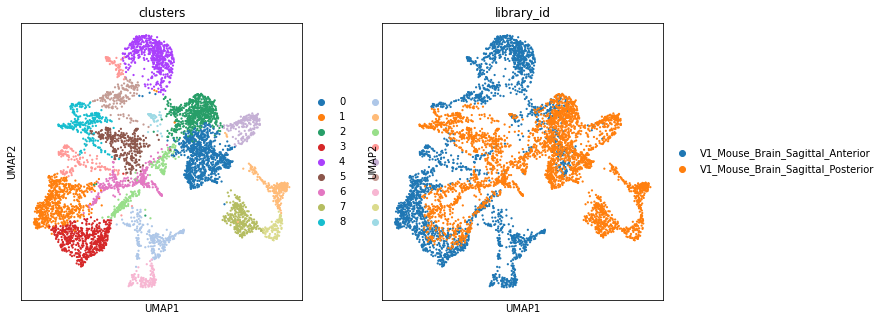

In [9]:
sc.pl.umap(
    adata_spatial, color=["clusters", "library_id"], palette=sc.pl.palettes.default_20
)

We can also visualize the clustering result in spatial coordinates. For that, we first need to save the cluster colors in a dictionary. We can then plot the Visium tissue fo the Anterior and Posterior Sagittal view, alongside each other.

In [10]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"])
)

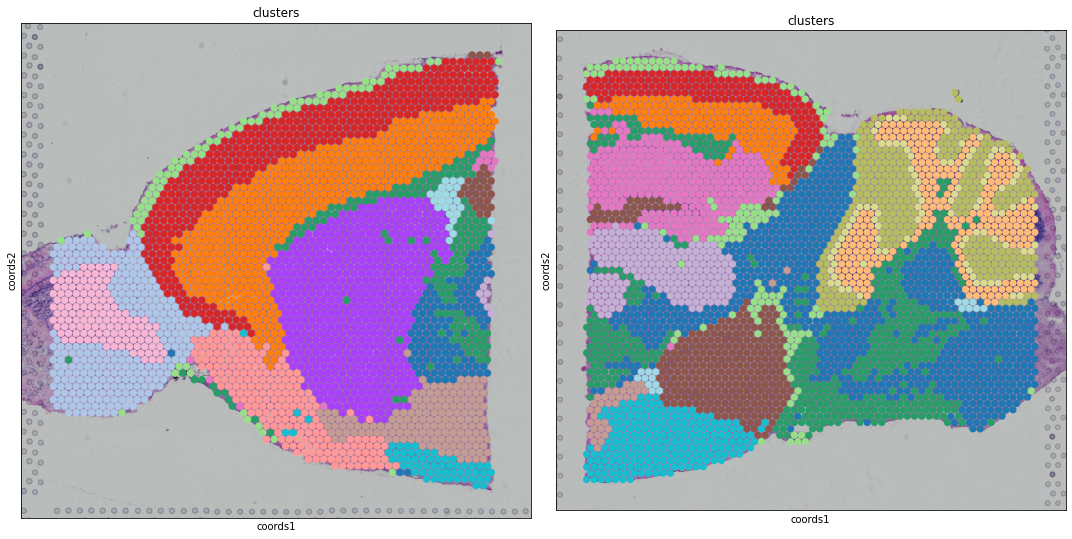

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

From the clusters, we can clearly see the stratification of the cortical layer in both of the tissues (see the [Allen brain atlas](https://mouse.brain-map.org/experiment/thumbnails/100042147?image_type=atlas) for reference). Furthermore, it seems that the dataset integration worked well, since there is a clear continuity between clusters in the two tissues. 

### Data integration and label transfer from scRNA-seq dataset

e can also perform data integration between one scRNA-seq dataset and one spatial transcriptomics dataset. Such task is particularly useful because it allows us to transfer cell type labels to the Visium dataset, which were dentified from the scRNA-seq dataset. 

For this task, we will be using a dataset from [Tasic et al.](https://www.nature.com/articles/s41586-018-0654-5), where the mouse cortex was profiled with smart-seq technology.

The dataset can be downloaded from **[GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115746)** [count](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115746/suppl/GSE115746_cells_exon_counts.csv.gz) - [metadata](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115746/suppl/GSE115746_complete_metadata_28706-cells.csv.gz).
Conveniently, you can also download the pre-processed dataset in h5ad format from [here](https://hmgubox.helmholtz-muenchen.de/f/4ef254675e2a41f89835/?dl=1).

Since the dataset was generated from the mouse cortex, we will subset the visium dataset in order to select only the spots part of the cortex. Note that the integration can also be performed on the whole brain slice, but it would give rise to false positive cell type assignments and and therefore it should be interpreted with more care.

The integration task will be performed with Scanorama: each Visium dataset will be integrated with the smart-seq cortex dataset.

In [12]:
adata_cortex = sc.read("./adata_processed.h5ad")

Subset the spatial anndata to (approximately) selects only spots belonging to the cortex.

In [13]:
adata_anterior_subset = adata_spatial_anterior[
    adata_spatial_anterior.obsm["coords"][:, 1] < 6000, :
]
adata_posterior_subset = adata_spatial_posterior[
    (adata_spatial_posterior.obsm["coords"][:, 1] < 4000)
    & (adata_spatial_posterior.obsm["coords"][:, 0] < 6000),
    :,
]

Run integration with Scanorama

In [14]:
adatas_anterior = [adata_cortex, adata_anterior_subset]
adatas_posterior = [adata_cortex, adata_posterior_subset]


# Integration.
integrated_anterior, corrected_anterior = scanorama.correct_scanpy(
    adatas_anterior, return_dimred=True
)
integrated_posterior, corrected_posterior = scanorama.correct_scanpy(
    adatas_posterior, return_dimred=True
)

Found 20125 genes among all datasets
[[0.         0.27150259]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 20125 genes among all datasets
[[0.         0.35665914]
 [0.         0.        ]]
Processing datasets (0, 1)


Concatenate datasets and assign integrated embeddings to anndata objects.

Notice that we are concatenating datasets with the `join="outer"` and `uns_merge="first"` strategies. This is because we want to keep the `obsm['coords']` as well as the images of the visium datasets.

In [15]:
adata_cortex_anterior = adata_cortex.concatenate(
    adata_anterior_subset,
    batch_key="dataset",
    batch_categories=["smart-seq", "visium"],
    join="outer",
    uns_merge="first",
)
adata_cortex_posterior = adata_cortex.concatenate(
    adata_posterior_subset,
    batch_key="dataset",
    batch_categories=["smart-seq", "visium"],
    join="outer",
    uns_merge="first",
)

/Users/giovanni.palla/Projects/anndata/anndata/_core/merge.py:453: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat([a.obs for a in adatas], ignore_index=True)
/Users/giovanni.palla/Projects/anndata/anndata/_core/merge.py:453: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat([a.obs for a in adatas], ignore_index=True)


In [16]:
embedding_anterior = np.concatenate(integrated_anterior, axis=0)
adata_cortex_anterior.obsm["scanorama_embedding"] = embedding_anterior

embedding_posterior = np.concatenate(integrated_posterior, axis=0)
adata_cortex_posterior.obsm["scanorama_embedding"] = embedding_posterior

At this step, we have integrated each visium dataset in a common embedding with the scRNA-seq dataset. In such embedding space, we can compute distances between samples and use such distances as *weights* to be used for for *propagating* labels from the scRNA-seq dataset to the Visium dataset. 

Such approach is very similar to the `TransferData` function in Seurat (see [paper](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8)). Here, we re-implement the label transfer function with a simple python function, see below.

Frist, let's compute cosine distances between the visium dataset and the scRNA-seq dataset, in the common embedding space

In [17]:
from sklearn.metrics.pairwise import cosine_distances

distances_anterior = 1 - cosine_distances(
    adata_cortex_anterior[adata_cortex_anterior.obs.dataset == "smart-seq"].obsm[
        "scanorama_embedding"
    ],
    adata_cortex_anterior[adata_cortex_anterior.obs.dataset == "visium"].obsm[
        "scanorama_embedding"
    ],
)
distances_posterior = 1 - cosine_distances(
    adata_cortex_posterior[adata_cortex_posterior.obs.dataset == "smart-seq"].obsm[
        "scanorama_embedding"
    ],
    adata_cortex_posterior[adata_cortex_posterior.obs.dataset == "visium"].obsm[
        "scanorama_embedding"
    ],
)

Then, let's propagate labels from the scRNA-seq dataset to the visium dataset

In [18]:
def label_transfer(dist, labels):
    lab = pd.get_dummies(labels).to_numpy().T
    class_prob = lab @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    return class_prob

In [19]:
class_prob_anterior = label_transfer(distances_anterior, adata_cortex.obs.cell_subclass)
class_prob_posterior = label_transfer(
    distances_posterior, adata_cortex.obs.cell_subclass
)

The `class_prob_[anterior-posterior]` objects is a numpy array of shape `(cell_type, visium_spots)` that contains *assigned weights* of each spots to each cell types. This value essentially tells us how similar that spots look like, from an expression profile perspective, to all the other annotated cell types from the scRNA-seq dataset.

We convert the `class_prob_[anterior-posterior]` object to a dataframe and assign it to the respective anndata

In [20]:
cp_anterior_df = pd.DataFrame(
    class_prob_anterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique())
)
cp_posterior_df = pd.DataFrame(
    class_prob_posterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique())
)

cp_anterior_df.index = adata_anterior_subset.obs.index
cp_posterior_df.index = adata_posterior_subset.obs.index

In [21]:
adata_anterior_subset_transfer = adata_anterior_subset.copy()
adata_anterior_subset_transfer.obs = pd.concat(
    [adata_anterior_subset.obs, cp_anterior_df], axis=1
)

adata_posterior_subset_transfer = adata_posterior_subset.copy()
adata_posterior_subset_transfer.obs = pd.concat(
    [adata_posterior_subset.obs, cp_posterior_df], axis=1
)

We are then able to explore how cell types are propagated from the scRNA-seq dataset to the visium dataset. Let's first visualize the neurons cortical layers.

... storing 'feature_types' as categorical
... storing 'genome' as categorical


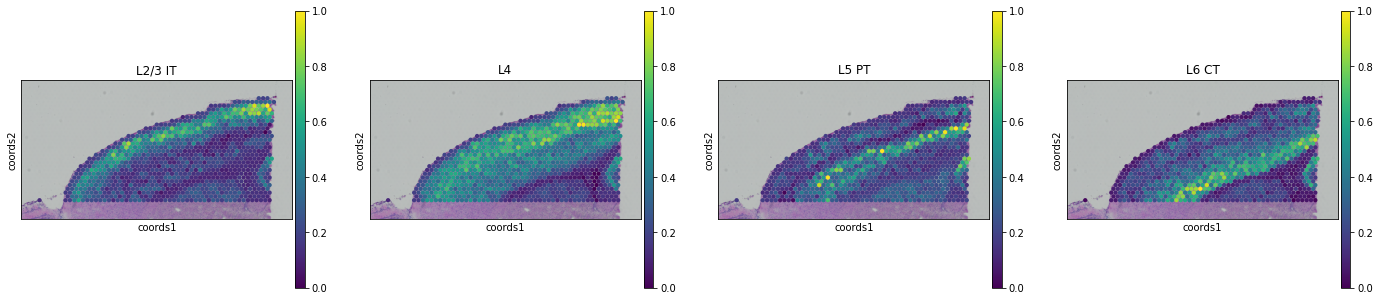

... storing 'feature_types' as categorical
... storing 'genome' as categorical


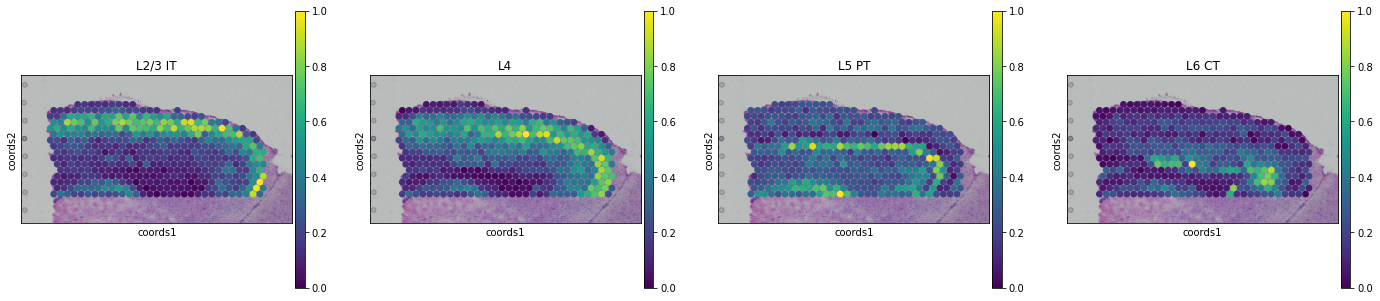

In [22]:
sc.pl.spatial(
    adata_anterior_subset_transfer,
    img_key="hires",
    color=["L2/3 IT", "L4", "L5 PT", "L6 CT"],
    size=1.5,
)
sc.pl.spatial(
    adata_posterior_subset_transfer,
    img_key="hires",
    color=["L2/3 IT", "L4", "L5 PT", "L6 CT"],
    size=1.5,
)

Interestingly, it seems that this approach worked, since sequential layers of cortical neurons could be correctly identified, both in the anterior and posterior sagittal slide.

We can go ahead an visualize astrocytes and oligodendrocytes as well.

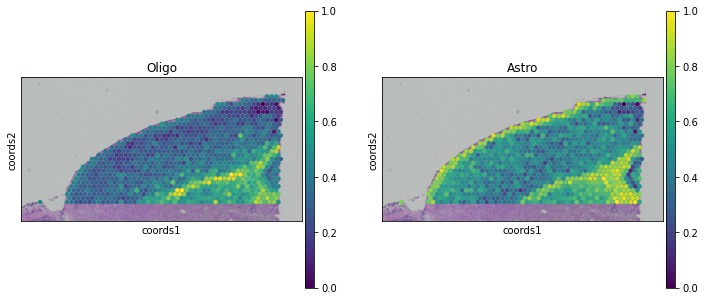

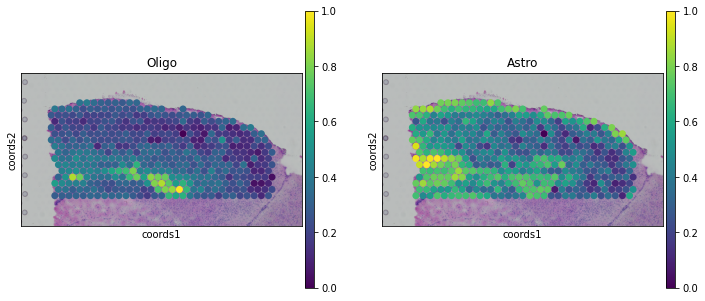

In [23]:
sc.pl.spatial(
    adata_anterior_subset_transfer, img_key="hires", color=["Oligo", "Astro"], size=1.5
)
sc.pl.spatial(
    adata_posterior_subset_transfer, img_key="hires", color=["Oligo", "Astro"], size=1.5
)

In this tutorial, we showed how to work with multiple slices in Scanpy, and perform label transfers between an annotated scRNA-seq dataset and an unannotated Visium dataset. We showed that such approach, that leverages the data integration performances of Scanorama, is useful and provide a straightforward tool for exploratory analysis.

However, for the label transfer task, we advise analysts to explore more principled approaches, based on cell-type deconvolution, that are likely to provide more accurate and interpretable results. See recent approaches such as:  
* **Stereoscope** [paper](https://www.biorxiv.org/content/10.1101/2019.12.13.874495v1) - [code](https://github.com/almaan/stereoscope)
* **AutogeneS** [paper](https://www.biorxiv.org/content/10.1101/2020.02.21.940650v1) - [code](https://github.com/theislab/AutoGeneS)
* **MuSiC** [paper](https://www.nature.com/articles/s41467-018-08023-x) - [code](https://github.com/xuranw/MuSiC)
* **CIBERSORT-X** [paper](https://www.nature.com/articles/s41587-019-0114-2) - [webtool](https://cibersortx.stanford.edu/)
* **Deconv-seq** [code](https://github.com/rosedu1/deconvSeq)